# Step 0. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow import keras

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras import optimizers
from keras.layers import Dropout

# Step 1. EDA

In [2]:
#Read data using pandas
plant_1_gen = pd.read_csv(r'/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
plant_2_gen = pd.read_csv(r'/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv')
plant_1_w = pd.read_csv(r'/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
plant_2_w = pd.read_csv(r'/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

In [3]:
plant_1_gen.head(5)

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [4]:
plant_2_w.head(5)

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [5]:
#Check shape of dataframes
print(plant_1_gen.shape)
print(plant_2_gen.shape)
print(plant_1_w.shape)
print(plant_2_w.shape)

(68778, 7)
(67698, 7)
(3182, 6)
(3259, 6)


<Axes: >

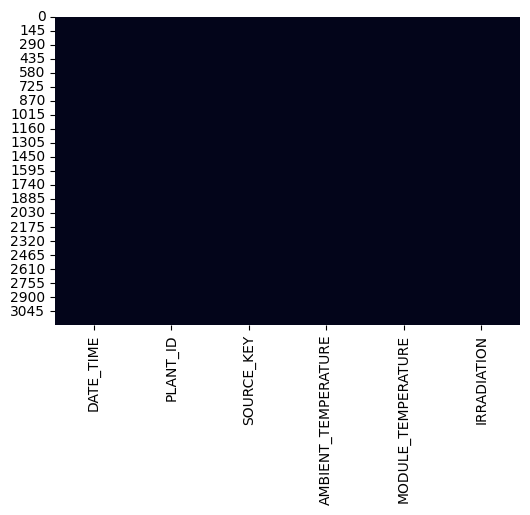

In [6]:
#Check for missing values
plt.figure(figsize=(6,4))
sns.heatmap(plant_1_w.isnull(),cbar=False)

#We have no missing values on either of the dataframes

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

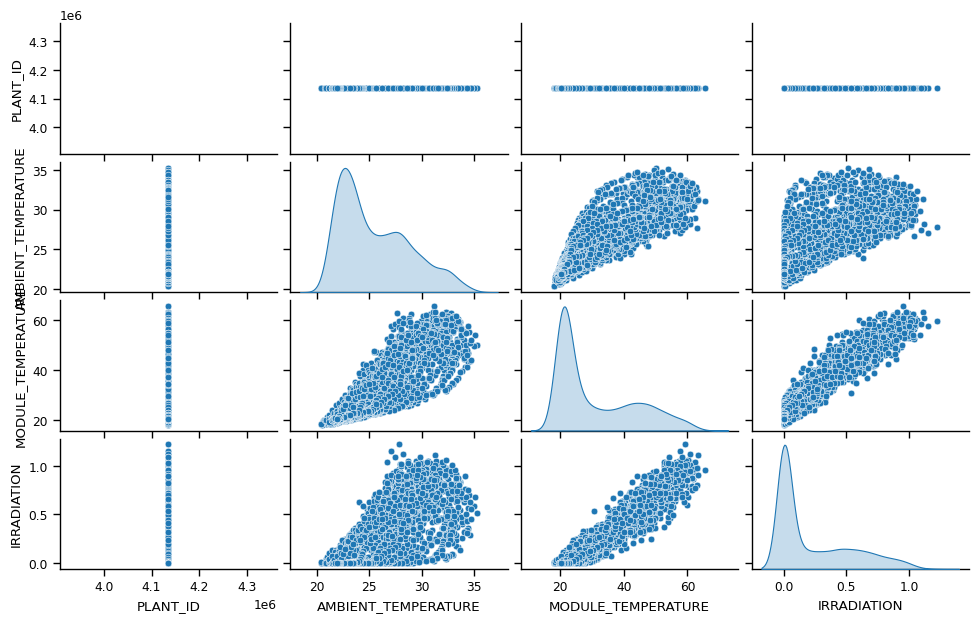

In [7]:
#Plot a pairplot for weather information
sns.set_context("paper")
g=sns.pairplot(data=plant_1_w, diag_kind='kde')
g.fig.set_size_inches(10,6)

In [8]:
#Check columns in generation and weather dataframes 
plant_1_gen.columns

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD'],
      dtype='object')

In [9]:
plant_2_w.columns

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'AMBIENT_TEMPERATURE',
       'MODULE_TEMPERATURE', 'IRRADIATION'],
      dtype='object')

In [10]:
#Finally let's check the range of the data
for feature in list(plant_1_gen.columns):
    try:
        print("Max value in ",feature,":",round(max(plant_1_gen[feature]), 2) )
        print("Min value in ",feature,":",round(min(plant_1_gen[feature]), 2) )
        
    except:
        pass

Max value in  PLANT_ID : 4135001
Min value in  PLANT_ID : 4135001
Max value in  DC_POWER : 14471.12
Min value in  DC_POWER : 0.0
Max value in  AC_POWER : 1410.95
Min value in  AC_POWER : 0.0
Max value in  DAILY_YIELD : 9163.0
Min value in  DAILY_YIELD : 0.0
Max value in  TOTAL_YIELD : 7846821.0
Min value in  TOTAL_YIELD : 6183645.0


In [11]:
#Finally let's check the range of the data
for feature in list(plant_2_w.columns):
    try:
        print("Max value in ",feature,":",round(max(plant_1_gen[feature]), 2) )
        print("Min value in ",feature,":",round(min(plant_1_gen[feature]), 2) )
        
    except:
        pass

Max value in  PLANT_ID : 4135001
Min value in  PLANT_ID : 4135001


# Step 2. Data preprocessing

## Step 2-1. Generation data

In [12]:
#Drop columns
plant_1_gen = plant_1_gen.drop(columns={'PLANT_ID', 'TOTAL_YIELD'})
plant_2_gen = plant_2_gen.drop(columns={'PLANT_ID', 'TOTAL_YIELD'})

In [13]:
#cast columns
plant_1_gen['DATE_TIME'] = pd.to_datetime(plant_1_gen['DATE_TIME'], format='%d-%m-%Y %H:%M')
plant_2_gen['DATE_TIME'] = pd.to_datetime(plant_2_gen['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

plant_1_gen['DC_POWER'] = plant_1_gen['DC_POWER'].apply(lambda row: float(row))
plant_1_gen['AC_POWER'] = plant_1_gen['AC_POWER'].apply(lambda row: float(row))
plant_1_gen['DAILY_YIELD'] = plant_1_gen['DAILY_YIELD'].apply(lambda row: float(row))

plant_2_gen['DC_POWER'] = plant_1_gen['DC_POWER'].apply(lambda row: float(row))
plant_2_gen['AC_POWER'] = plant_1_gen['AC_POWER'].apply(lambda row: float(row))
plant_2_gen['DAILY_YIELD'] = plant_1_gen['DAILY_YIELD'].apply(lambda row: float(row))

In [14]:
#Aggregate on plant basis
plant_1_gen = plant_1_gen.groupby('DATE_TIME').agg({'DC_POWER': 'sum', 'AC_POWER': 'sum', 'DAILY_YIELD': 'sum'}).reset_index()
plant_2_gen = plant_2_gen.groupby('DATE_TIME').agg({'DC_POWER': 'sum', 'AC_POWER': 'sum', 'DAILY_YIELD': 'sum'}).reset_index()

In [15]:
plant_1_gen.to_csv('plant_1_generation_clean.csv', index=False)

In [16]:
plant_2_gen.to_csv('plant_2_generation_clean.csv', index=False)

## Step 2-2 Weather Data

In [17]:
#Drop columns
plant_1_w = plant_1_w.drop(columns={'PLANT_ID', 'SOURCE_KEY'})
plant_2_w = plant_2_w.drop(columns={'PLANT_ID', 'SOURCE_KEY'})

In [18]:
#cast columns
plant_1_w['DATE_TIME'] = pd.to_datetime(plant_1_w['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
plant_2_w['DATE_TIME'] = pd.to_datetime(plant_2_w['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

plant_1_w['AMBIENT_TEMPERATURE'] = plant_1_w['AMBIENT_TEMPERATURE'].apply(lambda row: float(row))
plant_1_w['MODULE_TEMPERATURE']  = plant_1_w['MODULE_TEMPERATURE'].apply(lambda row: float(row))
plant_1_w['IRRADIATION'] = plant_1_w['IRRADIATION'].apply(lambda row: float(row))

plant_2_w['AMBIENT_TEMPERATURE'] = plant_2_w['AMBIENT_TEMPERATURE'].apply(lambda row: float(row))
plant_2_w['MODULE_TEMPERATURE']  = plant_2_w['MODULE_TEMPERATURE'].apply(lambda row: float(row))
plant_2_w['IRRADIATION'] = plant_2_w['IRRADIATION'].apply(lambda row: float(row))

In [19]:
plant_1_w.to_csv('plant_1_weather_clean.csv', index=False)

In [20]:
plant_2_w.to_csv('plant_2_weather_clean.csv', index=False)

## Step 2-3 Join dataframes

In [131]:
plant_1_merged = pd.merge(plant_1_gen, plant_1_w, on='DATE_TIME', how='inner')
plant_2_merged = pd.merge(plant_2_gen, plant_2_w, on='DATE_TIME', how='inner')

In [132]:
plant_1_merged.to_csv('plant_1_merged.csv', index=False)

In [133]:
plant_2_merged.to_csv('plant_2_merged.csv', index=False)

## Step 2-4 Finish pre processing for LSTM

In [156]:
#Now make this a function
def data_pre_process(plant_id, lag, delay):
    #Paths to documents containing data
    plant_1_path = '/kaggle/working/plant_1_merged.csv'
    plant_2_path = '/kaggle/working/plant_2_merged.csv'
    
    #Read df
    if plant_id == 1:
        df = pd.read_csv(plant_1_path)
    else:
        df = pd.read_csv(plant_2_path)
        
    #Re arrange df
    df = df.loc[:, ['DATE_TIME', 'DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 
                                'MODULE_TEMPERATURE', 'IRRADIATION', 'DAILY_YIELD']]
    df = df.set_index('DATE_TIME')
    
    #Now split data into X and y
    X = df.drop(columns={'DAILY_YIELD'})
    y = df['DAILY_YIELD']
    
    #Now let's scale data
    scaler_x = MinMaxScaler() #create scaler object
    scaled_data = scaler_x.fit_transform(X) #fit transform data
    
    #Split data into samples and reshape X
    samples = [scaled_data[i:i+delay] for i in range(0, (y.shape[0]), delay)]
    
    #Adjust last batch of observations
    if len(samples[-1]) < delay:
        samples = np.array(samples[:-1])
    else:
        samples = np.array(samples)
    
    #now re shape y
    new_y = [ y.iloc[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]
    #scale y 
    #scaler_y = MinMaxScaler()
    new_y = np.array(new_y)
    #scaled_y = scaler_y.fit_transform(new_y.reshape(1,-1))
    
    #Get label map
    index = df.index
    label_map = [index[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]
    
    return samples, new_y, scaler_x, lag, delay, label_map

In [186]:
X_1, y_1, x_scaler_1, lag_1, delay_1, label_map_1 = data_pre_process(plant_id=1, lag=1, delay=25)

In [145]:
np.sum(np.isnan(y_1))

0

In [146]:
np.sum(np.isnan(X_1))

0

In [147]:
len(label_map_1)

157

In [148]:
X_1.shape

(157, 20, 5)

In [149]:
y_1.shape

(157,)

# Step 3. Define & compile model

In [284]:
def lstm_model_init(X_train, verbose=True):
    #RNN-LSTM architechture
    keras.utils.set_random_seed(97) #Set seed for reproducibility
    lstm_model = Sequential(name='lstm_model')
    lstm_model.add(layers.LSTM(units=70, return_sequences=True, 
                               input_shape=(X_train[0].shape), activation="relu" )) 
    lstm_model.add(Dropout(0.2))
    lstm_model.add(layers.LSTM(units=70, return_sequences=False, activation="relu") )
    lstm_model.add(Dropout(0.2))
    lstm_model.add(layers.Dense(1))

    #Compile model
    optimizer = optimizers.Adam(learning_rate=0.001)
    lstm_model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    
    if verbose == True:
        print(lstm_model.summary())
    
    return lstm_model

def nn_model_init(X_train, verbose=True):
    #ANN architecture
    nn_model = Sequential(name='nn_model')
    nn_model.add(layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[-1])))
    nn_model.add(layers.Dense(20, activation='relu'))
    nn_model.add(layers.Dense(20, activation='relu'))
    nn_model.add(layers.Dense(1))
    
    #Compile model and fit
    nn_model.compile(optimizer='RMSprop', loss='mae')
    
    if verbose == True:
        print(nn_model.summary())
    
    return nn_model

In [285]:
del lstm_model
#del nn_model

In [286]:
lstm_model = lstm_model_init(X_1)
#nn_model = nn_model_init(X_1)

Model: "lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_79 (LSTM)                  │ (None, 25, 70)         │        21,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 25, 70)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ (None, 70)             │        39,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,831 (237.62 KB)

 Trainable params: 60,831 (237.62 KB)

 Non-trainable params: 0 (0.00 B)

None


In [287]:
#Train model
#X_1, y_1, x_scaler_1, lag_1, delay_1, label_map_1
lstm_history = lstm_model.fit(X_1, y_1, epochs=100, batch_size=2024, validation_split=0.2)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 73861.3438 - mae: 73861.3438 - val_loss: 71221.4766 - val_mae: 71221.4766
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 73861.3203 - mae: 73861.3203 - val_loss: 71221.4531 - val_mae: 71221.4531
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 73861.2969 - mae: 73861.2969 - val_loss: 71221.4375 - val_mae: 71221.4375
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 73861.2812 - mae: 73861.2812 - val_loss: 71221.4219 - val_mae: 71221.4219
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 73861.2578 - mae: 73861.2578 - val_loss: 71221.4062 - val_mae: 71221.4062
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 73861.2422 - mae: 73861.2422 - val_loss: 71221.3906 - val_mae: 71221.3906
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 73861.2109 - mae: 73861.2109 - val_loss: 71221.3594 - val_mae: 71221.3594
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 73861.1797 - m

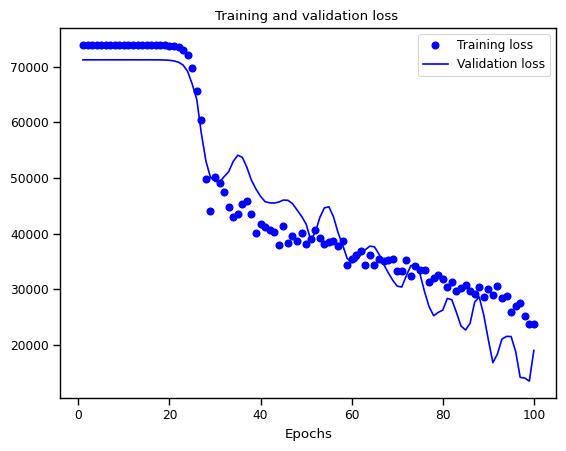

In [288]:
 #Plot training and validation loss
print("\n")
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss ')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


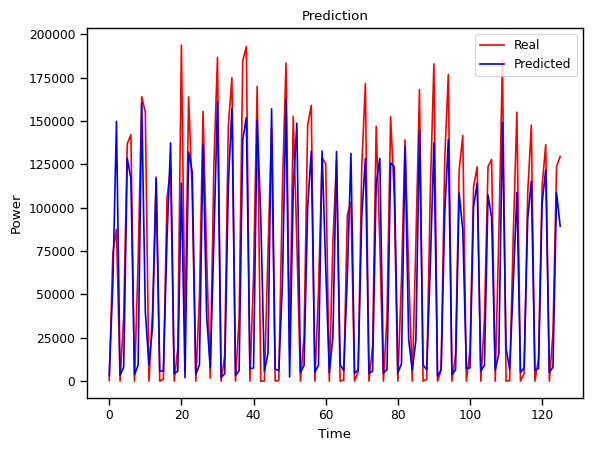

In [289]:
 #Make predictions and plot with correct values
predicted_power = lstm_model.predict(X_1)
plt.plot(y_1, color='red', label='Real')
plt.plot(predicted_power, color='blue', label='Predicted')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show()

In [290]:
  #Evaluate model
#Evaluate regression model using mse and map
print("MSE for model: ")
print(mean_squared_error(y_1, predicted_power))
print("\n")
print("MAPE for model: ")
print(mean_absolute_percentage_error(y_1, predicted_power))

MSE for model: 
993126643.1617324


MAPE for model: 
9.351640443785048e+18


# New Iteration for model

In [3]:
#Read CSVs
plant_1 = pd.read_csv('data/plant_1_merged.csv')
plant_2 = pd.read_csv('data/plant_2_merged.csv')

#Concat the dataframes
combined_plants = pd.concat([plant_1, plant_2])
combined_plants.reset_index(inplace=True, drop=True)

#Save new training dataframe
combined_plants.to_csv('data/combined_plants_3.csv', index=False)

In [1]:
#Function to pre process data
def data_pre_process(plant_id, lag, delay):
    #Paths to documents containing data
    plant_1_path = '/kaggle/working/plant_1_merged.csv'
    plant_2_path = '/kaggle/working/plant_2_merged.csv'
    plant_3_path = 'data/combined_plants_3.csv'
    
    #Read df
    if plant_id == 1:
        df = pd.read_csv(plant_1_path)
    elif plant_id == 2:
        df = pd.read_csv(plant_2_path)
    elif plant_id == 3:
        df = pd.read_csv(plant_3_path)
        
    #Re arrange df
    df = df.loc[:, ['DATE_TIME', 'DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 
                                'MODULE_TEMPERATURE', 'IRRADIATION', 'DAILY_YIELD']]
    #df = df.set_index('DATE_TIME')
    
    #Now split data into X and y
    X = df.drop(columns={'DAILY_YIELD', 'DATE_TIME'})
    y = df['DAILY_YIELD']
    
    #Now let's scale data
    scaler_x = MinMaxScaler() #create scaler object
    scaled_data = scaler_x.fit_transform(X) #fit transform data
    
    #Split data into samples and reshape X
    samples = [scaled_data[i:i+delay] for i in range(0, (y.shape[0]), delay)]
    
    #Adjust last batch of observations
    if len(samples[-1]) < delay:
        samples = np.array(samples[:-1])
    else:
        samples = np.array(samples)
    
    #now re shape y
    new_y = [ y.iloc[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]
    #scale y 
    #scaler_y = MinMaxScaler()
    new_y = np.array(new_y)
    #scaled_y = scaler_y.fit_transform(new_y.reshape(1,-1))
    
    #Get label map
    index = df.index
    label_map = [index[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]
    
    return samples, new_y, scaler_x, lag, delay, label_map

In [4]:
#Pre process data to train new model
X_1, y_1, x_scaler_1, lag_1, delay_1, label_map_1 = data_pre_process(plant_id=3, lag=1, delay=25)

In [5]:
#LSTM model
def lstm_model_init(X_train, verbose=True):
    #RNN-LSTM architechture
    keras.utils.set_random_seed(97) #Set seed for reproducibility
    lstm_model = Sequential(name='lstm_model')
    lstm_model.add(layers.LSTM(units=70, return_sequences=True, 
                               input_shape=(X_train[0].shape), activation="relu" )) 
    lstm_model.add(Dropout(0.2))
    lstm_model.add(layers.LSTM(units=35, return_sequences=False, activation="relu") )
    lstm_model.add(Dropout(0.2))
    lstm_model.add(layers.Dense(1))

    #Compile model
    optimizer = optimizers.Adam(learning_rate=0.001)
    lstm_model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    
    if verbose == True:
        print(lstm_model.summary())
    
    return lstm_model

In [6]:
#Define model
lstm_model = lstm_model_init(X_1, verbose=True)

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 70)            21280     
                                                                 
 dropout (Dropout)           (None, 25, 70)            0         
                                                                 
 lstm_1 (LSTM)               (None, 35)                14840     
                                                                 
 dropout_1 (Dropout)         (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 36156 (141.23 KB)
Trainable params: 36156 (141.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [8]:
#Train model
lstm_history = lstm_model.fit(X_1, y_1, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
7/7 [==============================] - 0s 53ms/step - loss: 70203.5234 - mae: 70203.5234 - val_loss: 72259.2734 - val_mae: 72259.2734
Epoch 2/200
7/7 [==============================] - 0s 33ms/step - loss: 70203.1953 - mae: 70203.1953 - val_loss: 72258.7812 - val_mae: 72258.7812
Epoch 3/200
7/7 [==============================] - 0s 33ms/step - loss: 70182.6094 - mae: 70182.6094 - val_loss: 72241.6250 - val_mae: 72241.6250
Epoch 4/200
7/7 [==============================] - 0s 35ms/step - loss: 69995.6328 - mae: 69995.6328 - val_loss: 72198.3984 - val_mae: 72198.3984
Epoch 5/200
7/7 [==============================] - 0s 48ms/step - loss: 69152.9141 - mae: 69152.9141 - val_loss: 71756.8047 - val_mae: 71756.8047
Epoch 6/200
7/7 [==============================] - 0s 45ms/step - loss: 59476.0781 - mae: 59476.0781 - val_loss: 65429.3477 - val_mae: 65429.3477
Epoch 7/200
7/7 [==============================] - 0s 44ms/step - loss: 46878.1680 - mae: 46878.1680 - val_loss: 64946.3828 

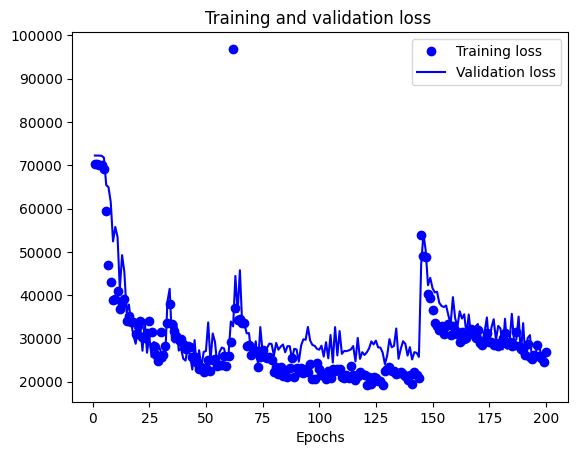

In [9]:
 #Plot training and validation loss
print("\n")
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss ')
plt.legend()
plt.show()

8/8 [==============================] - 1s 8ms/step


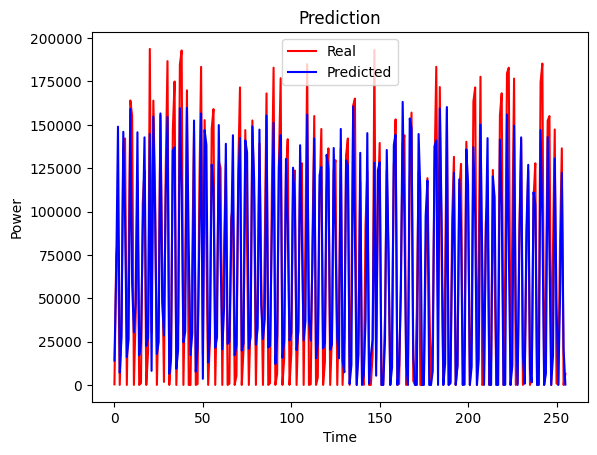

In [11]:
 #Make predictions and plot with correct values
predicted_power = lstm_model.predict(X_1)
plt.plot(y_1, color='red', label='Real')
plt.plot(predicted_power, color='blue', label='Predicted')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show()

In [12]:
#Evaluate regression model using mse and mape
predicted_power = lstm_model.predict(X_1)
print("MSE for model: ")
print(mean_squared_error(y_1, predicted_power))

8/8 [==============================] - 0s 11ms/step
MSE for model: 
880149236.3475735


In [13]:
lstm_model.save(r'Model/solar_prediction_2.keras')

# Baseline ANN

In [3]:
def nn_model_init(X_train, verbose=True):
    #ANN architecture
    nn_model = Sequential(name='nn_model')
    nn_model.add(layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[-1])))
    nn_model.add(layers.Dense(20, activation='relu'))
    nn_model.add(layers.Dense(20, activation='relu'))
    nn_model.add(layers.Dense(1))
    
    #Compile model and fit
    nn_model.compile(optimizer='RMSprop', loss='mae')
    
    if verbose == True:
        print(nn_model.summary())
    
    return nn_model

#Function to pre process data
def data_pre_process(plant_id, lag, delay):
    #Paths to documents containing data
    plant_1_path = '/kaggle/working/plant_1_merged.csv'
    plant_2_path = '/kaggle/working/plant_2_merged.csv'
    plant_3_path = 'data/combined_plants_3.csv'
    
    #Read df
    if plant_id == 1:
        df = pd.read_csv(plant_1_path)
    elif plant_id == 2:
        df = pd.read_csv(plant_2_path)
    elif plant_id == 3:
        df = pd.read_csv(plant_3_path)
        
    #Re arrange df
    df = df.loc[:, ['DATE_TIME', 'DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 
                                'MODULE_TEMPERATURE', 'IRRADIATION', 'DAILY_YIELD']]
    #df = df.set_index('DATE_TIME')
    
    #Now split data into X and y
    X = df.drop(columns={'DAILY_YIELD', 'DATE_TIME'})
    y = df['DAILY_YIELD']
    
    #Now let's scale data
    scaler_x = MinMaxScaler() #create scaler object
    scaled_data = scaler_x.fit_transform(X) #fit transform data
    
    #Split data into samples and reshape X
    samples = [scaled_data[i:i+delay] for i in range(0, (y.shape[0]), delay)]
    
    #Adjust last batch of observations
    if len(samples[-1]) < delay:
        samples = np.array(samples[:-1])
    else:
        samples = np.array(samples)
    
    #now re shape y
    new_y = [ y.iloc[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]
    #scale y 
    #scaler_y = MinMaxScaler()
    new_y = np.array(new_y)
    #scaled_y = scaler_y.fit_transform(new_y.reshape(1,-1))
    
    #Get label map
    index = df.index
    label_map = [index[i+delay+lag] for i in range(0, (y.shape[0]-(delay+lag)), delay)]
    
    return samples, new_y, scaler_x, lag, delay, label_map

In [4]:
#Pre process data to train new model
X_1, y_1, x_scaler_1, lag_1, delay_1, label_map_1 = data_pre_process(plant_id=3, lag=1, delay=25)

In [5]:
#Define model
baseline_model = nn_model_init(X_1, verbose=True)

Model: "nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 125)               0         
                                                                 
 dense (Dense)               (None, 20)                2520      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2961 (11.57 KB)
Trainable params: 2961 (11.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [6]:
#Train model
baseline_history = baseline_model.fit(X_1, y_1, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
7/7 [==============================] - 1s 50ms/step - loss: 70203.1797 - val_loss: 72259.0156
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 70202.3047 - val_loss: 72258.6094
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 70201.4375 - val_loss: 72258.1172
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 70200.4219 - val_loss: 72257.5547
Epoch 5/200
7/7 [==============================] - 0s 9ms/step - loss: 70199.2891 - val_loss: 72256.8906
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 70197.8906 - val_loss: 72256.1094
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 70196.3125 - val_loss: 72255.2891
Epoch 8/200
7/7 [==============================] - 0s 7ms/step - loss: 70194.6406 - val_loss: 72254.3984
Epoch 9/200
7/7 [==============================] - 0s 8ms/step - loss: 70192.7969 - val_loss: 72253.3594
Epoch 10/200
7/7 [==============================] - 0

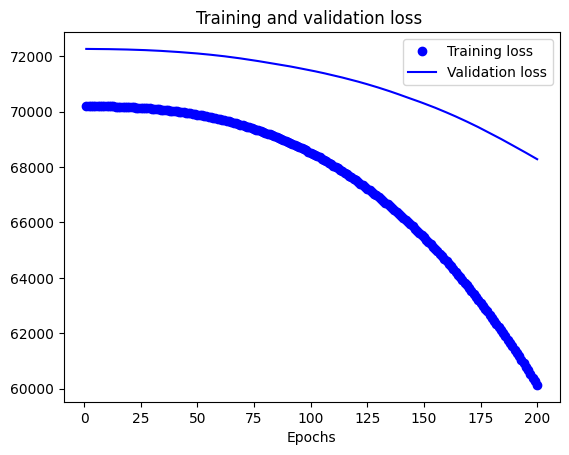

In [7]:
 #Plot training and validation loss
print("\n")
loss = baseline_history.history['loss']
val_loss = baseline_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss ')
plt.legend()
plt.show()

8/8 [==============================] - 0s 2ms/step


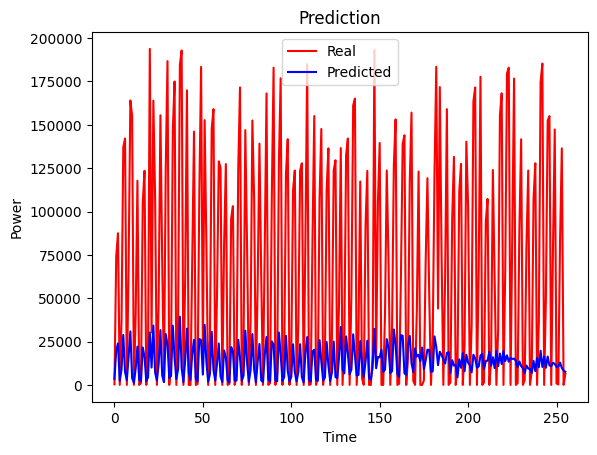

In [8]:
 #Make predictions and plot with correct values
predicted_power = baseline_model.predict(X_1)
plt.plot(y_1, color='red', label='Real')
plt.plot(predicted_power, color='blue', label='Predicted')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show()

In [9]:
#Evaluate regression model using mse and mape
predicted_power = baseline_model.predict(X_1)
print("MSE for model: ")
print(mean_squared_error(y_1, predicted_power))

8/8 [==============================] - 0s 1ms/step
MSE for model: 
6893321549.217755
